Импортируем библиотеки

Importing libraries

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

Перейдем к построению моделей

Let's move on to building models

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8903059	test: 0.8941294	best: 0.8941294 (0)	total: 1.53s	remaining: 50m 56s
100:	learn: 0.9452687	test: 0.9413196	best: 0.9413196 (100)	total: 8.43s	remaining: 2m 38s
200:	learn: 0.9524411	test: 0.9488658	best: 0.9489069 (198)	total: 15.8s	remaining: 2m 21s
300:	learn: 0.9556197	test: 0.9517196	best: 0.9517297 (294)	total: 23.1s	remaining: 2m 10s
400:	learn: 0.9580649	test: 0.9528596	best: 0.9529620 (396)	total: 29s	remaining: 1m 55s
500:	learn: 0.9600480	test: 0.9547197	best: 0.9547771 (499)	total: 35s	remaining: 1m 44s
600:	learn: 0.9624641	test: 0.9556359	best: 0.9558653 (598)	total: 40.3s	remaining: 1m 33s
700:	learn: 0.9633275	test: 0.9568437	best: 0.9569686 (697)	total: 45.5s	remaining: 1m 24s
800:	learn: 0.9644726	test: 0.9574270	best: 0.9574946 (795)	total: 50.7s	remaining: 1m 15s
900:	learn: 0.9652666	test: 0.9581560	best: 0.9581560 (899)	total: 56.8s	remaining: 1m 9s
1000:	learn: 0.9664340	test: 0.9583690	best: 0.9585615 (981)	total: 1m 2s	remaining: 1m 2s
1100:	l

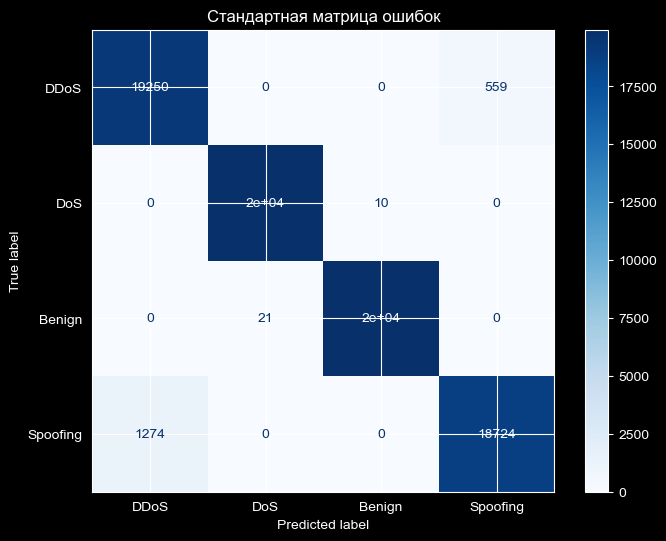

------train------
Accuracy: 0.977
Precision: 0.977
Recall: 0.977
------val------
Accuracy: 0.969
Precision: 0.969
Recall: 0.969
              precision    recall  f1-score   support

        DDoS     0.9240    0.9579    0.9407      5088
         DoS     0.9988    0.9988    0.9988      5004
      Benign     0.9988    0.9988    0.9988      4927
    Spoofing     0.9546    0.9181    0.9360      4899

    accuracy                         0.9685     19918
   macro avg     0.9690    0.9684    0.9686     19918
weighted avg     0.9688    0.9685    0.9685     19918



In [6]:
df = pd.read_csv('../data_eda/final_data.csv')

X = df.drop('category', axis=1)
y = df['category']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

class_weights = [1.8, 1.0, 1.0, 1.5]  # DDoS↑, Spoofing↑, остальные=1.0

cat_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=7,
    random_seed=42,
    early_stopping_rounds=50,
    random_strength=3,
    class_weights=class_weights,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    od_type='Iter',
    bootstrap_type='Bernoulli',
    devices='GPU',
    verbose=100,
    subsample=0.6
)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, plot=True)

cat_pred_train = cat_model.predict(X_train)
cat_pred_val = cat_model.predict(X_val)

cat_model_acc = accuracy_score(y_train, cat_pred_train)
cat_model_precision = precision_score(y_train, cat_pred_train, average='weighted')
cat_model_recall = recall_score(y_train, cat_pred_train, average='weighted')

cat_model_acc_val = accuracy_score(y_val, cat_pred_val)
cat_model_precision_val = precision_score(y_val, cat_pred_val, average='weighted')
cat_model_recall_val = recall_score(y_val, cat_pred_val, average='weighted')

cat_model_confusion = confusion_matrix(y_train, cat_pred_train)
class_name = ['DDoS', 'DoS', 'Benign', 'Spoofing']

fig, ax = plt.subplots(1, 1, figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cat_model_confusion, display_labels=class_name)
disp.plot(ax=ax, cmap='Blues')
ax.set_title('Стандартная матрица ошибок')
plt.show()

report = classification_report(
    y_val,
    cat_pred_val,
    target_names=class_name,
    digits=4
)

print('------train------')
print(f'Accuracy: {cat_model_acc:.3f}')
print(f'Precision: {cat_model_precision:.3f}')
print(f'Recall: {cat_model_recall:.3f}')
print('------val------')
print(f'Accuracy: {cat_model_acc_val:.3f}')
print(f'Precision: {cat_model_precision_val:.3f}')
print(f'Recall: {cat_model_recall_val:.3f}')
print(report)

Путаница между spoofing и ddos, добавим кастомный вес.
Попробовал варианты с [1.5, 1.0, 1.0, 1.3], [1.5, 1.0, 1.0, 1.4], [1.7, 1.0, 1.0, 1.5]. Лучше не стало поэтому остановлюсь на [1.5, 1.0, 1.0, 1.3].

Confusion between spoofing and ddos, let's add a custom weight.
I tried the options with [1.5, 1.0, 1.0, 1.3], [1.5, 1.0, 1.0, 1.4], [1.7, 1.0, 1.0, 1.5]. It didn't get any better, so I'll stop at [1.5, 1.0, 1.0, 1.3].

Протестируем lightgbm и сравним результаты.

Let's test lightgbm and compare the results.

In [17]:
lightgbm_model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=7,
    num_leaves=80,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=7,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    subsample=0.6,
    subsample_freq=1,
    colsample_bytree=0.8,
    class_weight={'DDoS': 1.8, 'DoS': 1.0, 'Benign': 1.0, 'Spoofing': 1.5},  # DDoS:1.8, Spoofing:1.5
    metric='multi_logloss',
    boosting_type='gbdt',
    objective='multiclass',
    num_class=4
)

lightgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[
        log_evaluation(period=100),
        early_stopping(stopping_rounds=50)  # ранняя остановка
    ]  # ранняя остановка
)

y_pred_train = lightgbm_model.predict(X_train)
y_pred_val = lightgbm_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train, average='weighted')
train_recall = recall_score(y_train, y_pred_train, average='weighted')

# Validation метрики
val_accuracy = accuracy_score(y_val, y_pred_val)
val_precision = precision_score(y_val, y_pred_val, average='weighted')
val_recall = recall_score(y_val, y_pred_val, average='weighted')

# Вывод метрик в том же формате
print("--- TRAIN ---")
print(f"Accuracy:  {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall:    {train_recall:.3f}")

print("\n--- VALIDATION ---")
print(f"Accuracy:  {val_accuracy:.3f}")
print(f"Precision: {val_precision:.3f}")
print(f"Recall:    {val_recall:.3f}")
report = classification_report(y_val, y_pred_val, target_names=class_name, digits=4)
print(report)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 0.107166
[200]	valid_0's multi_logloss: 0.0779398
[300]	valid_0's multi_logloss: 0.0716839
[400]	valid_0's multi_logloss: 0.0693527
[500]	valid_0's multi_logloss: 0.0681998
[600]	valid_0's multi_logloss: 0.0677706
[700]	valid_0's multi_logloss: 0.0675751
Early stopping, best iteration is:
[664]	valid_0's multi_logloss: 0.067502
--- TRAIN ---
Accuracy:  0.992
Precision: 0.992
Recall:    0.992

--- VALIDATION ---
Accuracy:  0.970
Precision: 0.970
Recall:    0.970
              precision    recall  f1-score   support

        DDoS     0.9436    0.9401    0.9418      5088
         DoS     0.9994    0.9990    0.9992      5004
      Benign     0.9990    0.9994    0.9992      4927
    Spoofing     0.9380    0.9416    0.9398      4899

    accuracy                         0.9699     19918
   macro avg     0.9700    0.9700    0.9700     19918
weighted avg     0.9699    0.9699    0.9699     19918



модельки +- одинаковые получились, lightgbm чуть быстрее, думаю ее и оставлю

The + models turned out to be the same, lightgbm is a little faster, I think I'll leave it

In [22]:
os.makedirs('models_final', exist_ok=True)
model_path = 'models_final/lightgbm_model.pkl'
model = lightgbm_model
joblib.dump(model, model_path)

['models_final/lightgbm_model.pkl']